In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import re

import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import multiprocessing
from gensim.models import Word2Vec, KeyedVectors

from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import roc_auc_score, f1_score

[nltk_data] Downloading package stopwords to /home/louis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2022-03-28 10:00:11.029446: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-28 10:00:11.029469: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
EMBEDDING_DIM = 300

In [3]:
train_df = pd.read_csv('data/train.csv.zip')
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# CLEANING FUNCTIONS

STOP_WORD = stopwords.words('english')

def clean_comment(comment):
    comment = comment.lower()
    comment = remove_special_chars(comment)
    comment = remove_stop_words(comment)
    
    return comment


def remove_special_chars(comment):
    comment = re.sub("(\\W)"," ", comment).strip()
    comment = re.sub('\S*\d\S*\s*','', comment).strip()
    comment = re.sub(' +', ' ', comment)
    
    return comment


def remove_stop_words(comment):
    comment = " ".join([word for word in comment.split() if word not in STOP_WORD])
    
    return comment 

In [5]:
### INIT TRAIN ###
train_df['comment_text'] = train_df['comment_text'].apply(clean_comment)
list_comment_train = list(train_df['comment_text'])

In [6]:
# tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list_comment_train)
encoded_comment_train = tokenizer.texts_to_sequences(list_comment_train)

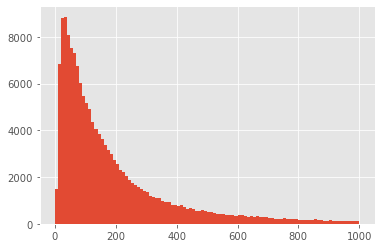

In [7]:
total_num_words = [len(comment) for comment in list_comment_train]
plt.hist(total_num_words, bins=np.arange(0, 1010, 10))
plt.show()

In [8]:
# padding
MAX_LENGTH = 400
VOCAB_SIZE = len(tokenizer.word_index) + 1
X_train = pad_sequences(encoded_comment_train, maxlen=MAX_LENGTH, padding='post')

In [9]:
### INIT TEST ###
test_df = pd.read_csv('data/test.csv.zip')
test_df['comment_text'] = train_df['comment_text'].apply(clean_comment)
list_comment_test = list(test_df['comment_text'])

encoded_comment_test = tokenizer.texts_to_sequences(list_comment_test)
X_test = pad_sequences(encoded_comment_test, maxlen=MAX_LENGTH, padding='post')

In [10]:
word2vec_model = KeyedVectors.load_word2vec_format('embeddings/GoogleNews-vectors-negative300.bin', binary=True)

In [14]:
word2vec_model[0].size

300

In [12]:
word2vec_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
words = tokenizer.word_index

for word in words:
    index = words[word]

    try:
        vector = word2vec_model[word]
        word2vec_matrix[index] = vector
    except:
        pass

In [ ]:
def create_model():
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[word2vec_matrix], input_length=MAX_LENGTH, trainable=False))
    model.add(LSTM(60, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.1))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(6, activation="sigmoid"))

    return model


def train_model(model, X_train, y_train):
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=2, validation_split=0.1, batch_size=64, verbose=1)

    return model, history

In [ ]:
model = create_model()
model.summary()

In [ ]:
y_train = train_df[LABELS]

model, history = train_model(model, X_train, y_train)

In [ ]:
y_test = model.predict([X_test], batch_size=1024, verbose=1)
sample_submission = pd.read_csv(f'data/sample_submission.csv.zip')
sample_submission[list_classes] = y_test
sample_submission.to_csv(f'submission_LSTM_word2vec.csv', index=False)